In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [87]:
df = pd.read_csv('temperature_data.csv')

In [88]:
df.head(10)

,city,timestamp,temperature,season
0,New York,2010-01-01,0.000409,winter
1,New York,2010-01-02,7.854304,winter
2,New York,2010-01-03,-0.784680,winter
3,New York,2010-01-04,0.252577,winter
4,New York,2010-01-05,1.031893,winter
5,New York,2010-01-06,7.726369,winter
6,New York,2010-01-07,-4.639910,winter
7,New York,2010-01-08,1.938323,winter
8,New York,2010-01-09,-4.968356,winter
9,New York,2010-01-10,-16.455437,winter


In [89]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         54750 non-null  object 
 1   timestamp    54750 non-null  object 
 2   temperature  54750 non-null  float64
 3   season       54750 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


,temperature
count,54750.000000
mean,18.300096
std,11.064874
min,-24.546595
25%,11.230983
50%,18.793419
75%,26.075129
max,57.284904


In [90]:
df.shape
n_rows = df.shape[0]
n_columns = df.shape[1]
print('Количество строк:', n_rows)
print('Количество столбцов:', n_columns)

Количество строк: 54750
Количество столбцов: 4


In [91]:
df.isnull().sum()

,0
city,0
timestamp,0
temperature,0
season,0


In [92]:
total = df.isnull().sum().sum()
print("Общее количество пропусков:", total)
column = df.isnull().sum()
m_columns = column[column > 0]
print(m_columns)

Общее количество пропусков: 0
Series([], dtype: int64)


# 1. Анализ данных


**Анализ исторических данных:**

* Вычислить скользящее среднее температуры с окном в 30 дней для сглаживания
краткосрочных колебаний.

* Рассчитать среднюю температуру и стандартное отклонение для каждого сезона в каждом городе.

* Выявить аномалии, где температура выходит за пределы  среднее ±2σ.

* Распараллелить проведение этого анализа. Сравнить скорость выполнения анализа с распараллеливанием и без него.

## Проанализируем среднюю температуру за период месяц и год

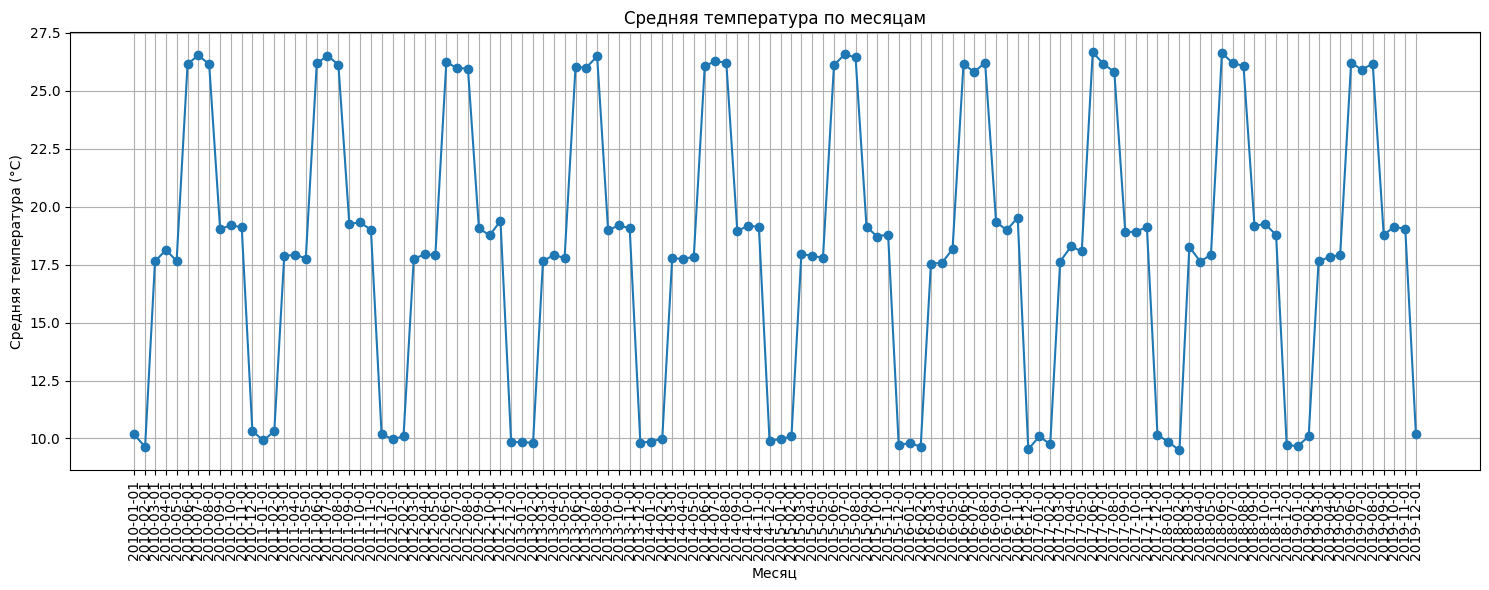

In [93]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year_month'] = df['timestamp'].dt.to_period('M')
monthly_mean = df.groupby('year_month')['temperature'].mean().reset_index()
monthly_mean['year_month'] = monthly_mean['year_month'].dt.to_timestamp()

plt.figure(figsize=(15, 6))
plt.plot(monthly_mean['year_month'], monthly_mean['temperature'], marker='o')
plt.title('Средняя температура по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя температура (°C)')
plt.grid()
plt.xticks(monthly_mean['year_month'], rotation=90)
plt.tight_layout()
plt.show()

In [94]:
print(f"Средняя температура: {monthly_mean}")

Средняя температура:     year_month  temperature
0   2010-01-01    10.175280
1   2010-02-01     9.635506
2   2010-03-01    17.636617
3   2010-04-01    18.135135
4   2010-05-01    17.652230
..         ...          ...
115 2019-08-01    26.162480
116 2019-09-01    18.788002
117 2019-10-01    19.124635
118 2019-11-01    19.039405
119 2019-12-01    10.176641

[120 rows x 2 columns]


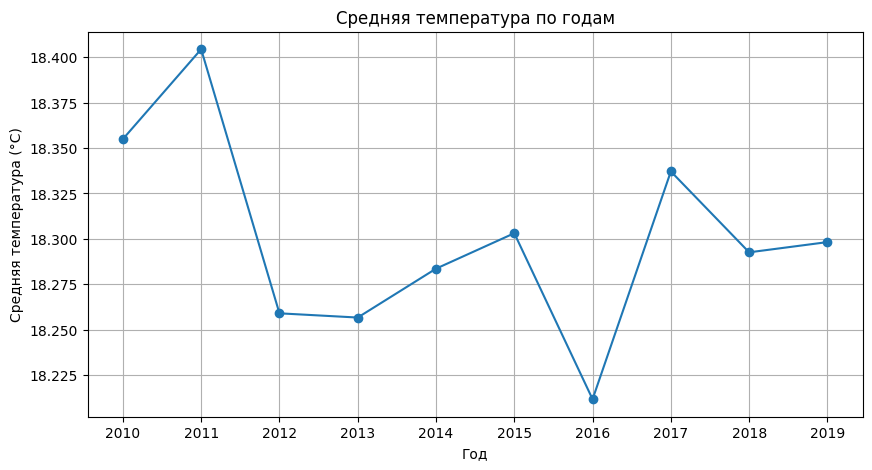

In [95]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
annual_mean = df.groupby('year')['temperature'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(annual_mean['year'], annual_mean['temperature'], marker='o')
plt.title('Средняя температура по годам')
plt.xlabel('Год')
plt.ylabel('Средняя температура (°C)')
plt.grid()
plt.xticks(annual_mean['year'])
plt.show()

## Расчитаем средние температуры и стандартные отклонения для каждого гороода и сезона.

In [96]:
mean_and_std = df.groupby(['city', 'season'])['temperature'].agg(['mean', 'std']).reset_index()

In [97]:
mean_and_std.head(10)

,city,season,mean,std
0,Beijing,autumn,15.853474,4.887798
1,Beijing,spring,12.894771,4.762848
2,Beijing,summer,27.092795,5.090230
3,Beijing,winter,-2.029613,5.119930
4,Berlin,autumn,11.132309,4.995600
5,Berlin,spring,9.818799,5.104025
6,Berlin,summer,19.652731,5.095002
7,Berlin,winter,-0.392317,5.262821
8,Cairo,autumn,25.310017,5.172651
9,Cairo,spring,24.955990,4.840348


In [98]:
mean_and_std.shape
number_rows = mean_and_std.shape[0]
number_columns = mean_and_std.shape[1]
print('Количество строк:', number_rows)
print('Количество столбцов:', number_columns)

Количество строк: 60
Количество столбцов: 4


In [99]:
number_rows = mean_and_std.shape[0]
print('Количество строк:', number_rows)

Количество строк: 60


Посчитаем отклонения 2 сигмы (где температура выходит за пределы  среднее±2σ) от средней температуры по сезону.

In [100]:
df = df.merge(mean_and_std, on=['city', 'season'])

In [101]:
df.shape

(54750, 8)

## Распараллелим анализ и сравним скорость   




In [102]:
import joblib

In [103]:
%%time

df['anomalies_2sigma'] = (df['temperature'] > (df['mean'] + 2 * df['std'])) | \
                (df['temperature'] < (df['mean'] - 2 * df['std']))

CPU times: user 3.18 ms, sys: 5 µs, total: 3.19 ms
Wall time: 5.48 ms


## Распараллеливание расчетов

In [104]:
%%time

from joblib import Parallel, delayed

avg_upper_2sigma = df['mean'] + 2 * df['std']
avg_lower_2sigma = df['mean'] - 2 * df['std']
def calcul_anomalies_2sigma(temp, upper_bound, lower_bound):
    return (temp > upper_bound) | (temp < lower_bound)
df['parallel_anomalies_2sigma'] = Parallel(n_jobs=-1)(
    delayed(calcul_anomalies_2sigma)(temp, avg_upper_2sigma.iloc[0], avg_lower_2sigma.iloc[0]) for temp in df['temperature']
)

CPU times: user 1.44 s, sys: 134 ms, total: 1.57 s
Wall time: 2.2 s


In [105]:
import time
start_time = time.time()
df['anomalies_2sigma'] = (df['temperature'] > (df['mean'] + 2 * df['std'])) | \
                          (df['temperature'] < (df['mean'] - 2 * df['std']))
end_time = time.time()
print(f"Время выполнения: {end_time - start_time} секунд")

Время выполнения: 0.0023550987243652344 секунд


In [106]:
import time
start_time = time.time()
df['parallel_anomalies_2sigma'] = Parallel(n_jobs=-1)(
    delayed(calcul_anomalies_2sigma)(temp, avg_upper_2sigma.iloc[0], avg_lower_2sigma.iloc[0]) for temp in df['temperature']
)
end_time = time.time()
print(f"Время выполнения: {end_time - start_time} секунд")

Время выполнения: 1.2784740924835205 секунд


In [107]:
anomalies_2s = df[df['anomalies_2sigma'] == True]
anomalies_2s.head()

,city,timestamp,temperature,season,year_month,year,mean,std,anomalies_2sigma,parallel_anomalies_2sigma
9,New York,2010-01-10,-16.455437,winter,2010-01,2010,-0.317731,4.951403,True,True
17,New York,2010-01-18,-10.262572,winter,2010-01,2010,-0.317731,4.951403,True,True
25,New York,2010-01-26,-11.164005,winter,2010-01,2010,-0.317731,4.951403,True,True
43,New York,2010-02-13,10.731692,winter,2010-02,2010,-0.317731,4.951403,True,True
81,New York,2010-03-23,24.831064,spring,2010-03,2010,10.046537,4.915154,True,True


In [108]:
anomalies_2s.shape

(2447, 10)

2447 наблюдений отличаются от годовой температуры более чем на 2 стандартных отклонения

## вычисление выбросов  >3 сигм.

---



In [109]:
%%time
df['anomalies_3sigma'] = (df['temperature'] > (df['mean'] + 3 * df['std'])) | \
                (df['temperature'] < (df['mean'] - 3 * df['std']))


CPU times: user 3.24 ms, sys: 976 µs, total: 4.22 ms
Wall time: 4.1 ms


In [110]:
import time
start_time = time.time()
df['anomalies_3sigma'] = (df['temperature'] > (df['mean'] + 3 * df['std'])) | \
                (df['temperature'] < (df['mean'] - 3 * df['std']))
end_time = time.time()
print(f"Время выполнения: {end_time - start_time} секунд")

Время выполнения: 0.002980947494506836 секунд


In [111]:
%%time

from joblib import Parallel, delayed
avg_upper_3sigma = df['mean'] + 3 * df['std']
avg_lower_3sigma = df['mean'] - 3 * df['std']
def calcul_anomalies_3sigma(temp, upper_bound, lower_bound):
    return (temp > upper_bound) | (temp < lower_bound)
df['parallel_anomalies_3sigma'] = Parallel(n_jobs=-1)(
    delayed(calcul_anomalies_3sigma)(temp, avg_upper_3sigma.iloc[0], avg_lower_3sigma.iloc[0]) for temp in df['temperature']
)

CPU times: user 1.28 s, sys: 11.9 ms, total: 1.29 s
Wall time: 1.32 s


In [112]:
import time
start_time = time.time()
df['parallel_anomalies_3sigma'] = Parallel(n_jobs=-1)(
    delayed(calcul_anomalies_3sigma)(temp, avg_upper_3sigma.iloc[0], avg_lower_3sigma.iloc[0]) for temp in df['temperature']
)
end_time = time.time()
print(f"Время выполнения: {end_time - start_time} секунд")

Время выполнения: 1.7800548076629639 секунд


При параллельном расчете результат хуже


In [113]:
anomalies_3s = df[df['anomalies_3sigma'] == True]
anomalies_3s.head()

,city,timestamp,temperature,season,year_month,year,mean,std,anomalies_2sigma,parallel_anomalies_2sigma,anomalies_3sigma,parallel_anomalies_3sigma
9,New York,2010-01-10,-16.455437,winter,2010-01,2010,-0.317731,4.951403,True,True,True,True
81,New York,2010-03-23,24.831064,spring,2010-03,2010,10.046537,4.915154,True,True,True,True
90,New York,2010-04-01,26.400453,spring,2010-04,2010,10.046537,4.915154,True,True,True,True
635,New York,2011-09-28,32.425605,autumn,2011-09,2011,15.160534,4.997276,True,True,True,True
1478,New York,2014-01-18,-17.010696,winter,2014-01,2014,-0.317731,4.951403,True,True,True,True


In [114]:
anomalies_3s.shape

(131, 12)

131 наблюдение отличается от годовой температуры более чем на 3 стандартных отклонения.

## Наибольшие и наименьшие значения температуры

In [115]:
temp_anomalies_3s = anomalies_3s.sort_values(by='temperature', ascending=False)

In [116]:
temp_anomalies_3s.head(10)

,city,timestamp,temperature,season,year_month,year,mean,std,anomalies_2sigma,parallel_anomalies_2sigma,anomalies_3sigma,parallel_anomalies_3sigma
33030,Dubai,2010-06-30,57.284904,summer,2010-06,2010,39.913733,5.167130,True,True,True,True
35967,Dubai,2018-07-15,56.410924,summer,2018-07,2018,39.913733,5.167130,True,True,True,True
44794,Mumbai,2012-09-21,48.032650,autumn,2012-09,2012,30.041118,4.969017,True,True,True,True
46012,Mumbai,2016-01-22,47.371326,winter,2016-01,2016,25.178291,4.793387,True,True,True,True
44474,Mumbai,2011-11-06,45.849612,autumn,2011-11,2011,30.041118,4.969017,True,True,True,True
42874,Singapore,2017-06-17,45.835219,summer,2017-06,2017,27.750942,5.180457,True,True,True,True
30447,Rio de Janeiro,2013-06-01,45.470097,summer,2013-06,2013,30.186513,4.933529,True,True,True,True
2039,New York,2015-08-02,43.183875,summer,2015-08,2015,24.863823,4.957424,True,True,True,True
40798,Singapore,2011-10-11,42.582038,autumn,2011-10,2011,27.026103,4.994778,True,True,True,True
50990,Cairo,2019-09-11,42.165352,autumn,2019-09,2019,25.310017,5.172651,True,True,True,True


In [117]:
temp_anomalies_3s.tail(10)

,city,timestamp,temperature,season,year_month,year,mean,std,anomalies_2sigma,parallel_anomalies_2sigma,anomalies_3sigma,parallel_anomalies_3sigma
15409,Moscow,2012-03-20,-10.082254,spring,2012-03,2012,5.033052,4.964520,True,False,True,False
4435,London,2012-02-25,-11.179131,winter,2012-02,2012,4.891972,5.184599,True,True,True,False
9527,Paris,2016-02-06,-12.116506,winter,2016-02,2016,3.971027,4.919682,True,True,True,False
16926,Moscow,2016-05-15,-13.325883,spring,2016-05,2016,5.033052,4.964520,True,True,True,False
5841,London,2016-01-01,-13.632992,winter,2016-01,2016,4.891972,5.184599,True,True,True,False
9,New York,2010-01-10,-16.455437,winter,2010-01,2010,-0.317731,4.951403,True,True,True,True
1478,New York,2014-01-18,-17.010696,winter,2014-01,2014,-0.317731,4.951403,True,True,True,True
28839,Beijing,2019-01-03,-18.002527,winter,2019-01,2019,-2.029613,5.119930,True,True,True,True
24426,Berlin,2016-12-01,-19.071616,winter,2016-12,2016,-0.392317,5.262821,True,True,True,True
26316,Beijing,2012-02-06,-19.386812,winter,2012-02,2012,-2.029613,5.119930,True,True,True,True


In [129]:
df_temp = pd.DataFrame(temp_anomalies_3s)
max_temp_index = temp_anomalies_3s['temperature'].idxmax()
max_city = temp_anomalies_3s.loc[max_temp_index, 'city']
max_temperature = temp_anomalies_3s.loc[max_temp_index, 'temperature']
print(f"Город с максимальной температурой: {max_city}, Максимальная температура: {max_temperature:.2f}°C")
min_temp_index = temp_anomalies_3s['temperature'].idxmin()
min_city = temp_anomalies_3s.loc[min_temp_index, 'city']
min_temperature = temp_anomalies_3s.loc[min_temp_index, 'temperature']
print(f"Город с минимальной температурой: {min_city}, Минимальная температура: {min_temperature:.2f}°C")


Город с максимальной температурой: Dubai, Максимальная температура: 57.28°C
Город с минимальной температурой: Beijing, Минимальная температура: -19.39°C


In [119]:
mean_and_std[mean_and_std['city'] == 'Moscow']


,city,season,mean,std
28,Moscow,autumn,7.911734,4.979186
29,Moscow,spring,5.033052,4.964520
30,Moscow,summer,17.932503,4.886798
31,Moscow,winter,-10.052067,5.100363


<Axes: >

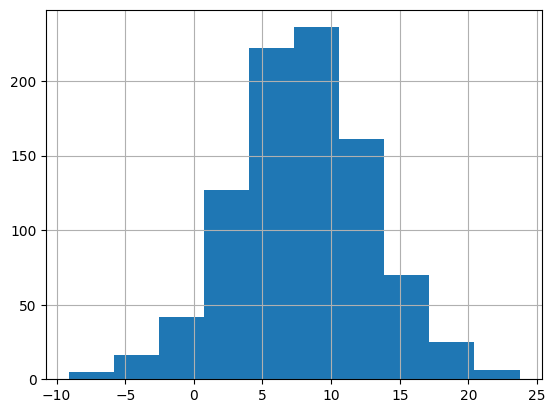

In [120]:
# df = pd.read_csv('temperature_data.csv')
df[(df['city'] == 'Moscow') & (df['season'] == 'autumn')]['temperature'].hist()

На графике, который получен в начале, наблюдается заметное смещение температур в отрицательную область, предположительно, из-за зафиксированной аномально низкой температуры.

In [121]:
df.head(10)

,city,timestamp,temperature,season,year_month,year,mean,std,anomalies_2sigma,parallel_anomalies_2sigma,anomalies_3sigma,parallel_anomalies_3sigma
0,New York,2010-01-01,0.000409,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
1,New York,2010-01-02,7.854304,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
2,New York,2010-01-03,-0.784680,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
3,New York,2010-01-04,0.252577,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
4,New York,2010-01-05,1.031893,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
5,New York,2010-01-06,7.726369,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
6,New York,2010-01-07,-4.639910,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
7,New York,2010-01-08,1.938323,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
8,New York,2010-01-09,-4.968356,winter,2010-01,2010,-0.317731,4.951403,False,False,False,False
9,New York,2010-01-10,-16.455437,winter,2010-01,2010,-0.317731,4.951403,True,True,True,True


In [122]:
df['MA'] = df['temperature'].rolling(window=50).mean()

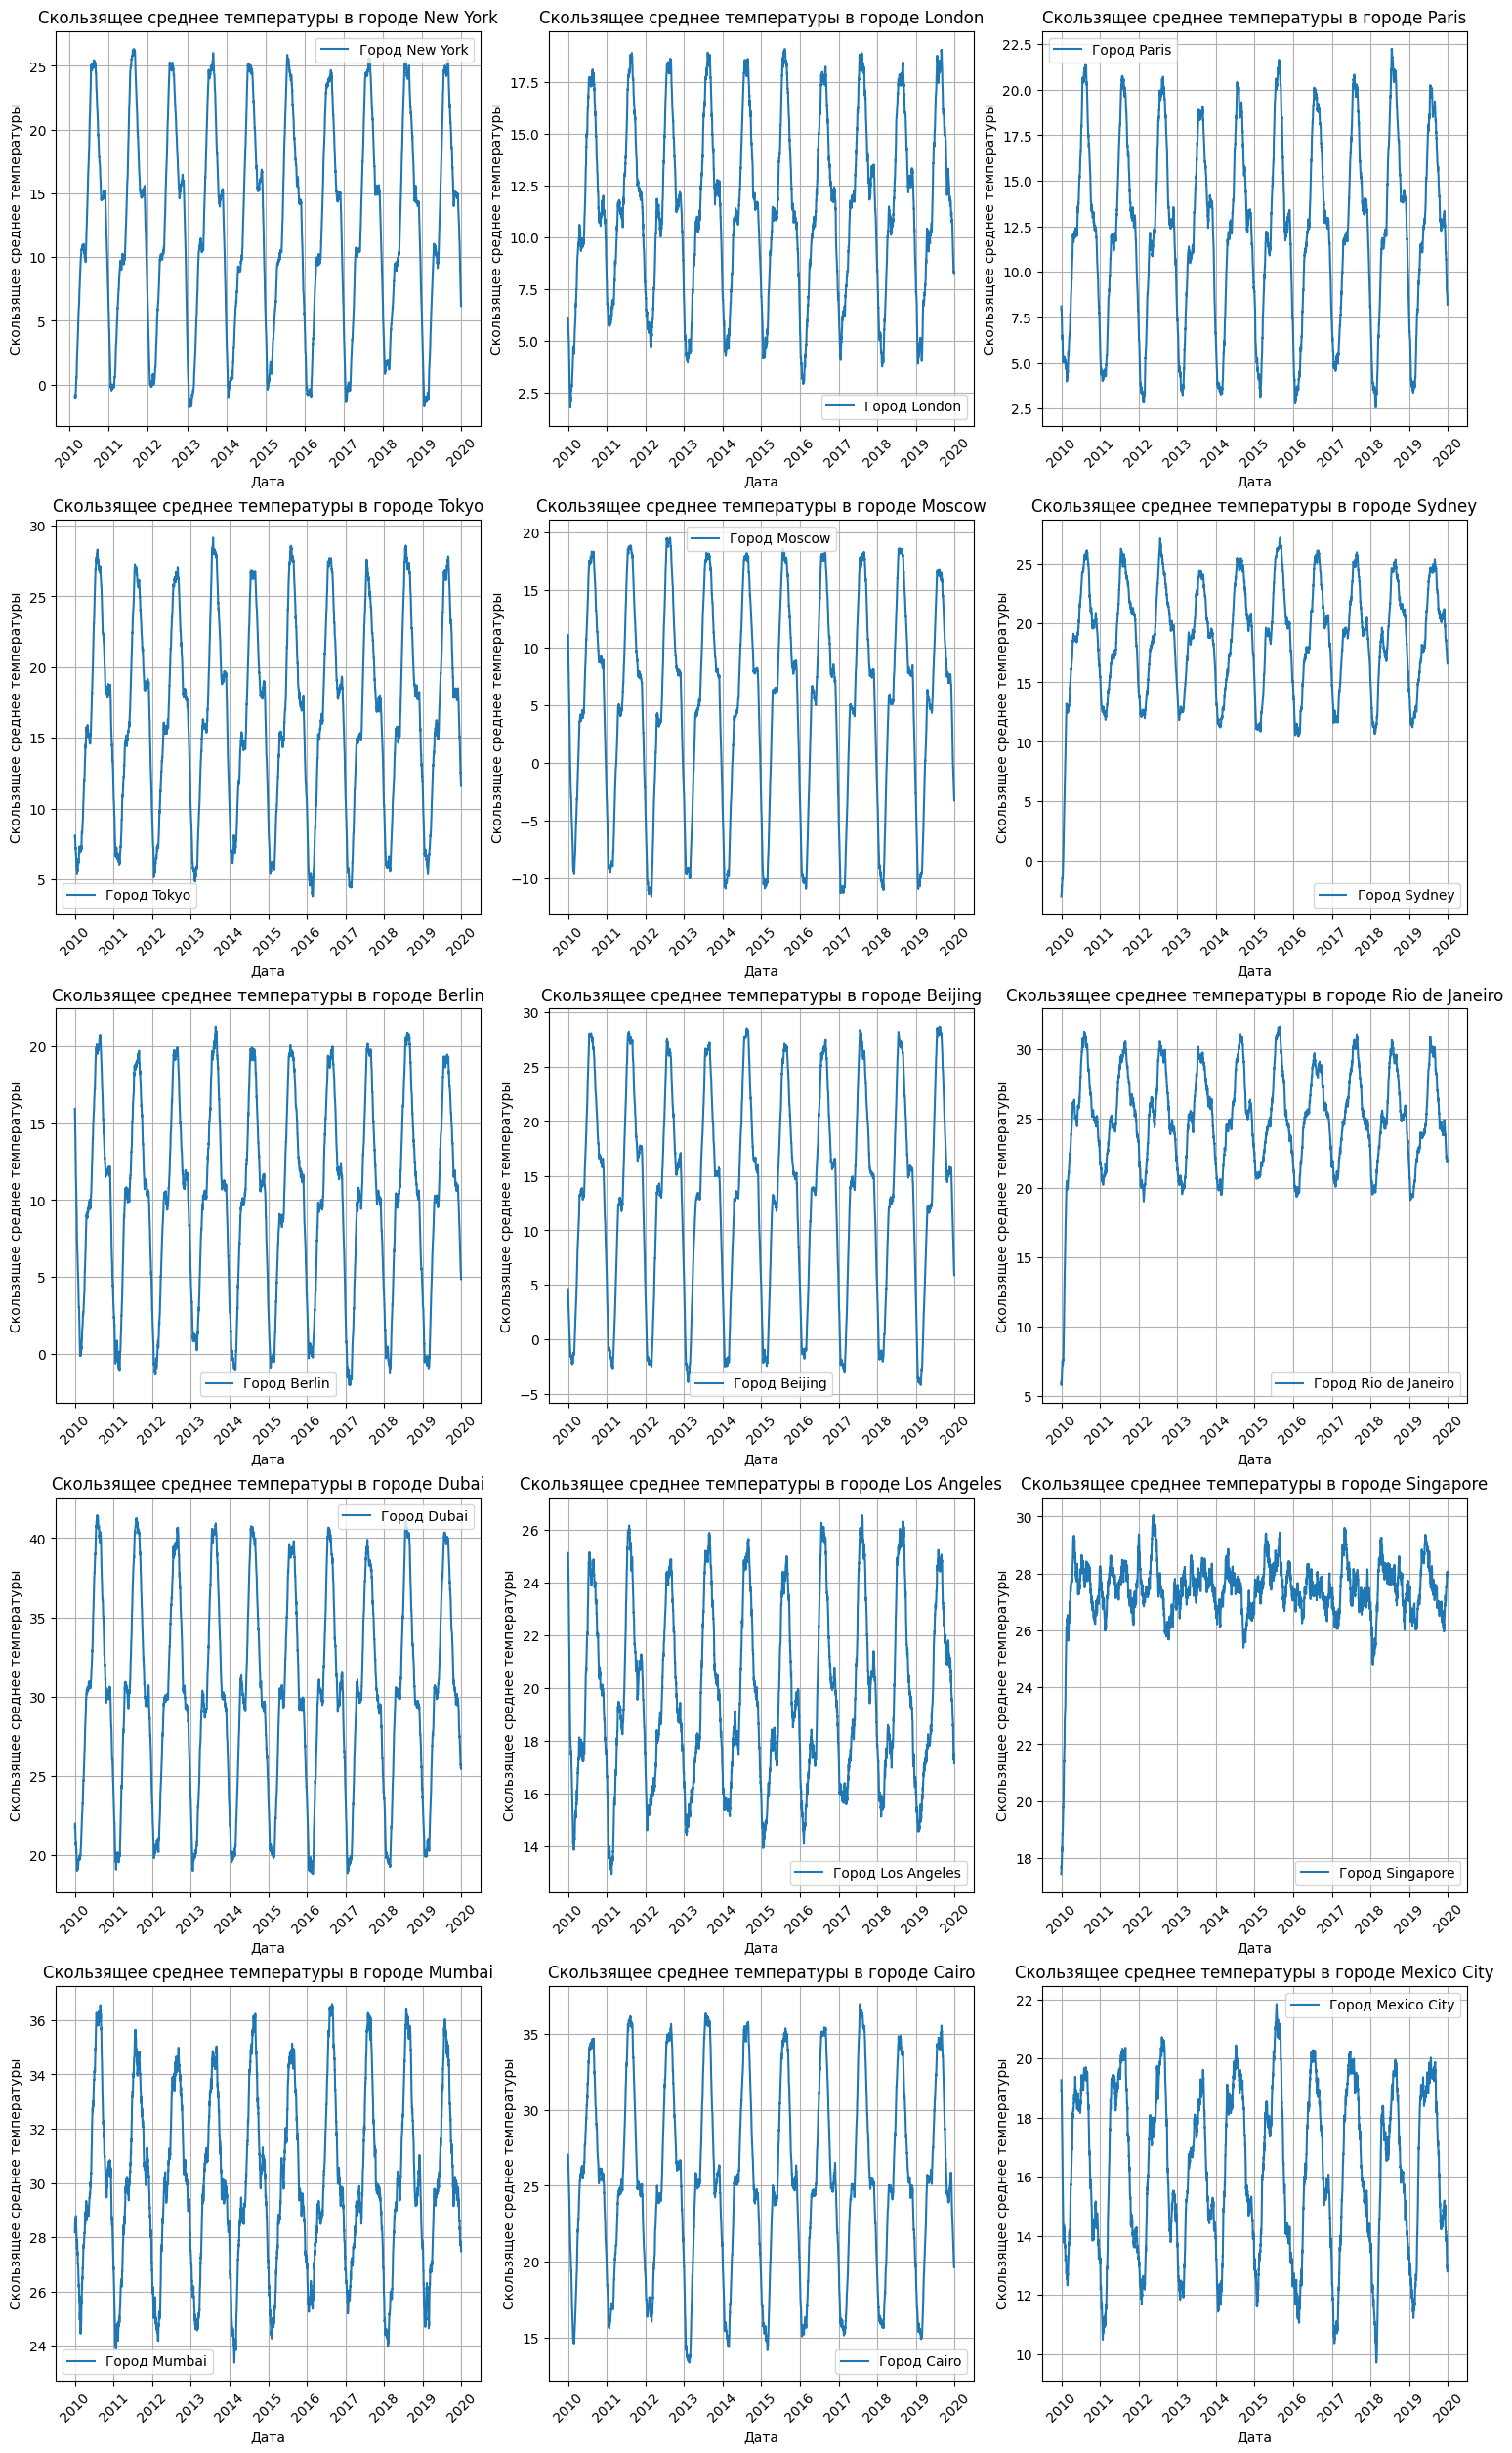

In [123]:
import pandas as pd
df = pd.DataFrame(df)
city_un = df['city'].unique()
num = len(city_un)
cols = 3
rows = (num + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)
axes = axes.flatten()
for i, city in enumerate(city_un):
    city_data = df[df['city'] == city]
    axes[i].plot(city_data['timestamp'], city_data['MA'], label=f'Город {city}')
    axes[i].set_title(f'Скользящее среднее температуры в городе {city}')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Скользящее среднее температуры')
    axes[i].legend()
    axes[i].grid()
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

На графиках видно, что в городах Сидней, Рио-де-женейро, Сингапур имеются аномальные выбросы температур.

In [124]:
city_del = ['Singapore','Sydney', 'Rio de Janeiro']

In [125]:
%%time
df_city_del_1 = df[~((df['city'].isin(city_del)) & (df['timestamp'] <= '2010-03-30'))]

CPU times: user 9.61 ms, sys: 0 ns, total: 9.61 ms
Wall time: 11.4 ms


In [126]:
import time
start_time = time.time()
df_city_del_1 = df[~((df['city'].isin(city_del)) & (df['timestamp'] <= '2009-03-30'))]
end_time = time.time()
print(f"Время выполнения: {end_time - start_time} секунд")

Время выполнения: 0.010508298873901367 секунд


In [127]:
%%time
def city_del_city(row):
    return not (row['city'] in city_del and row['timestamp'] <= pd.to_datetime('2010-03-30'))
starw = Parallel(n_jobs=-1)(delayed(city_del_city)(row) for index, row in df.iterrows())

df_city_del_2 = df[starw]

CPU times: user 17 s, sys: 101 ms, total: 17.1 s
Wall time: 23.6 s


In [128]:
import time
start_time = time.time()
def city_del_city(row):
    return not (row['city'] in city_del and row['timestamp'] <= pd.to_datetime('2010-03-30'))
starw = Parallel(n_jobs=-1)(delayed(city_del_city)(row) for index, row in df.iterrows())
end_time = time.time()
print(f"Время выполнения: {end_time - start_time} секунд")

Время выполнения: 23.6023588180542 секунд


Распараллеливание привело к повышению времени выполнения.

In [130]:
df = df[starw]

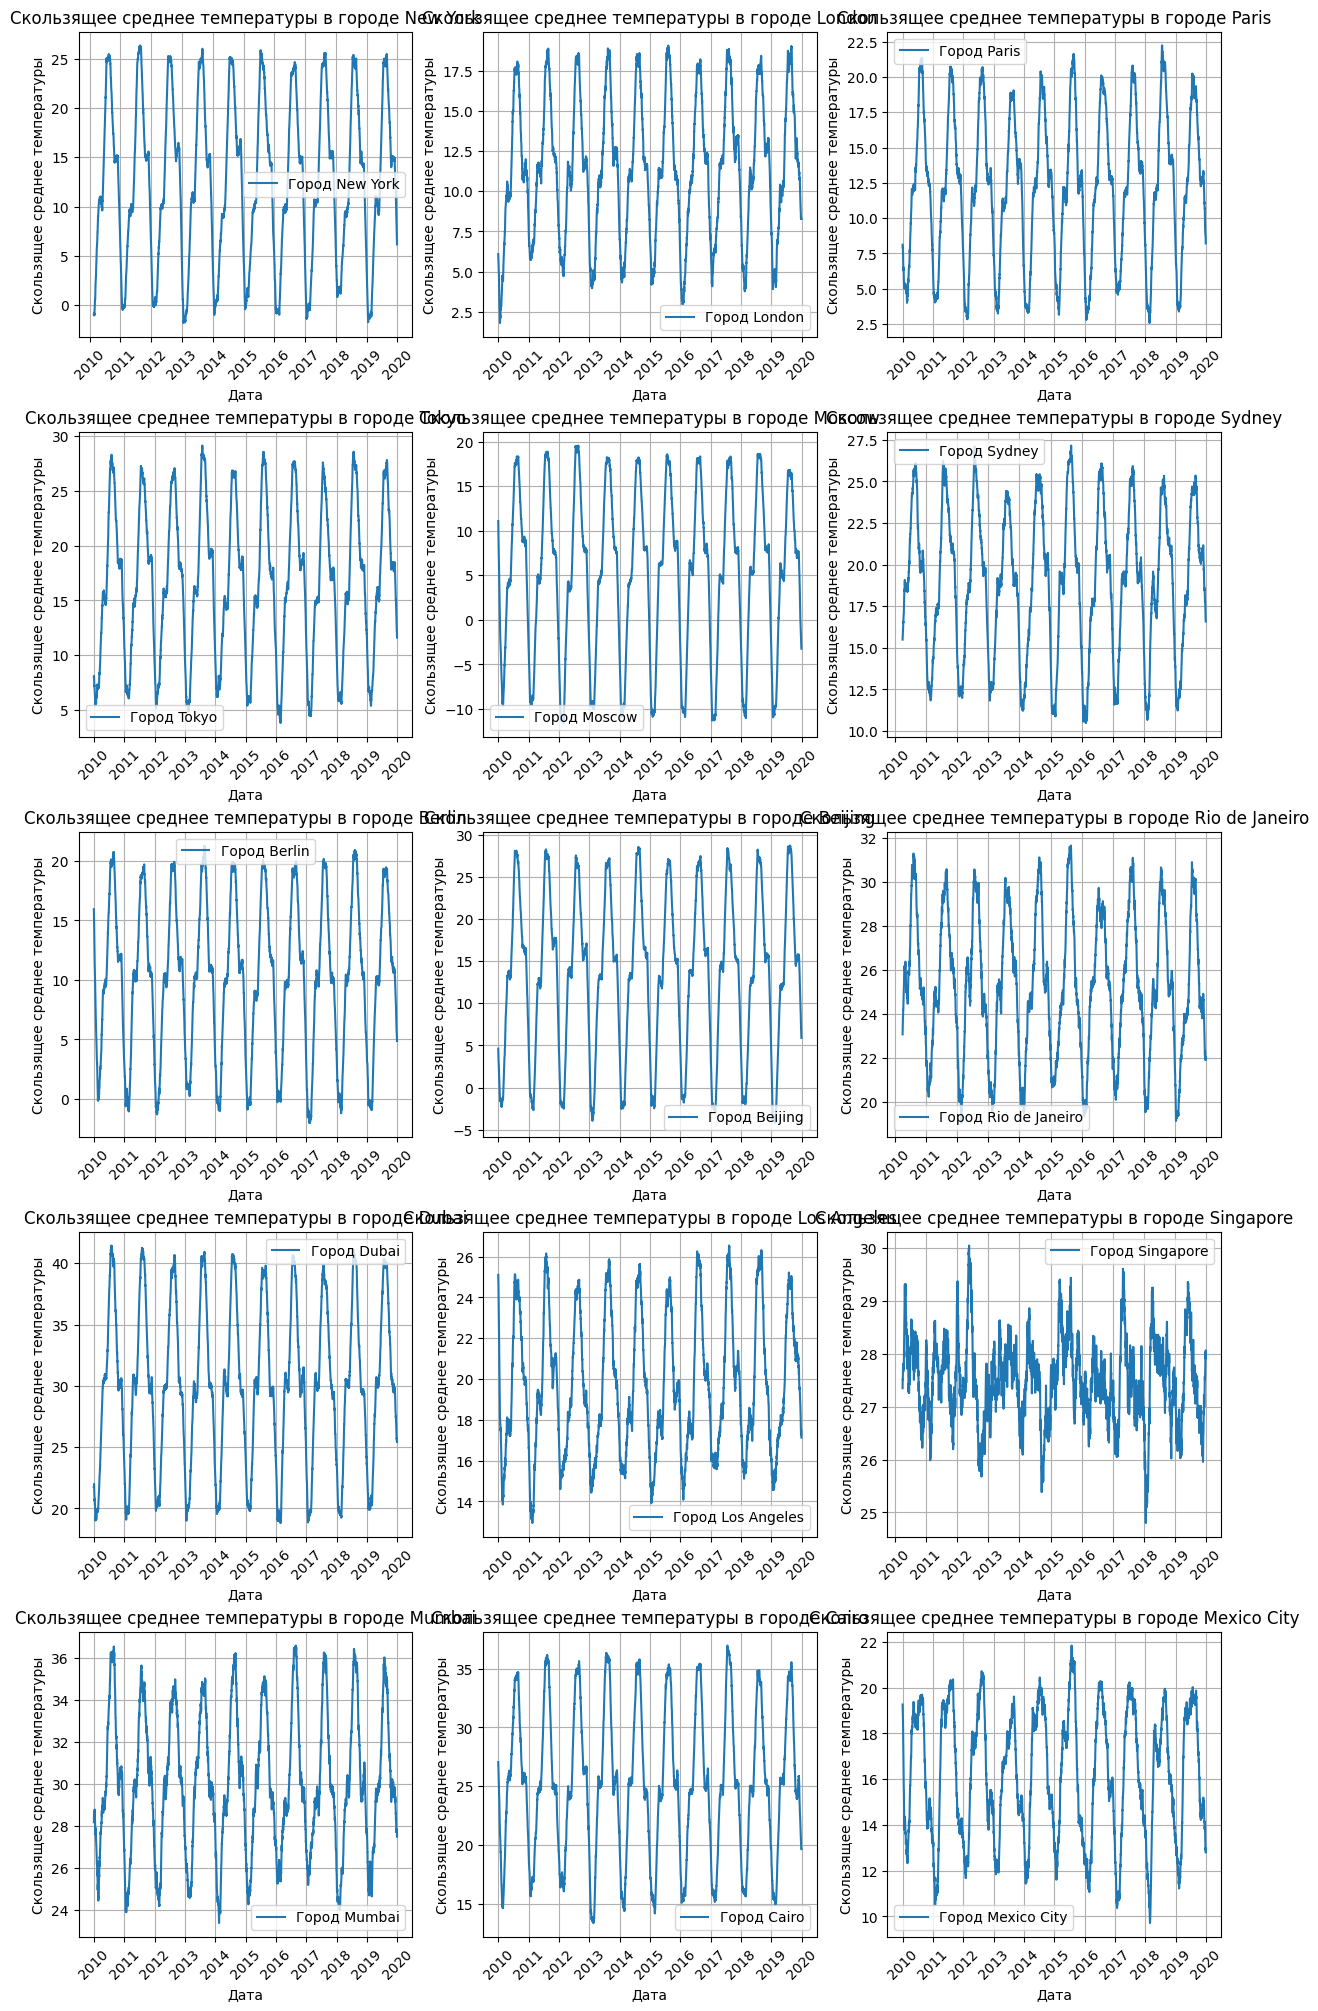

In [131]:
city_un_2 = df['city'].unique()
num = len(city_un_2)
cols = 3
rows = (num + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
axes = axes.flatten()
for i, city in enumerate(city_un_2):
    city_data = df[df['city'] == city]
    axes[i].plot(city_data['timestamp'], city_data['MA'], label=f'Город {city}')
    axes[i].set_title(f'Скользящее среднее температуры в городе {city}')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Скользящее среднее температуры')
    axes[i].legend()
    axes[i].grid()
    axes[i].tick_params(axis='x', rotation=45)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.show()

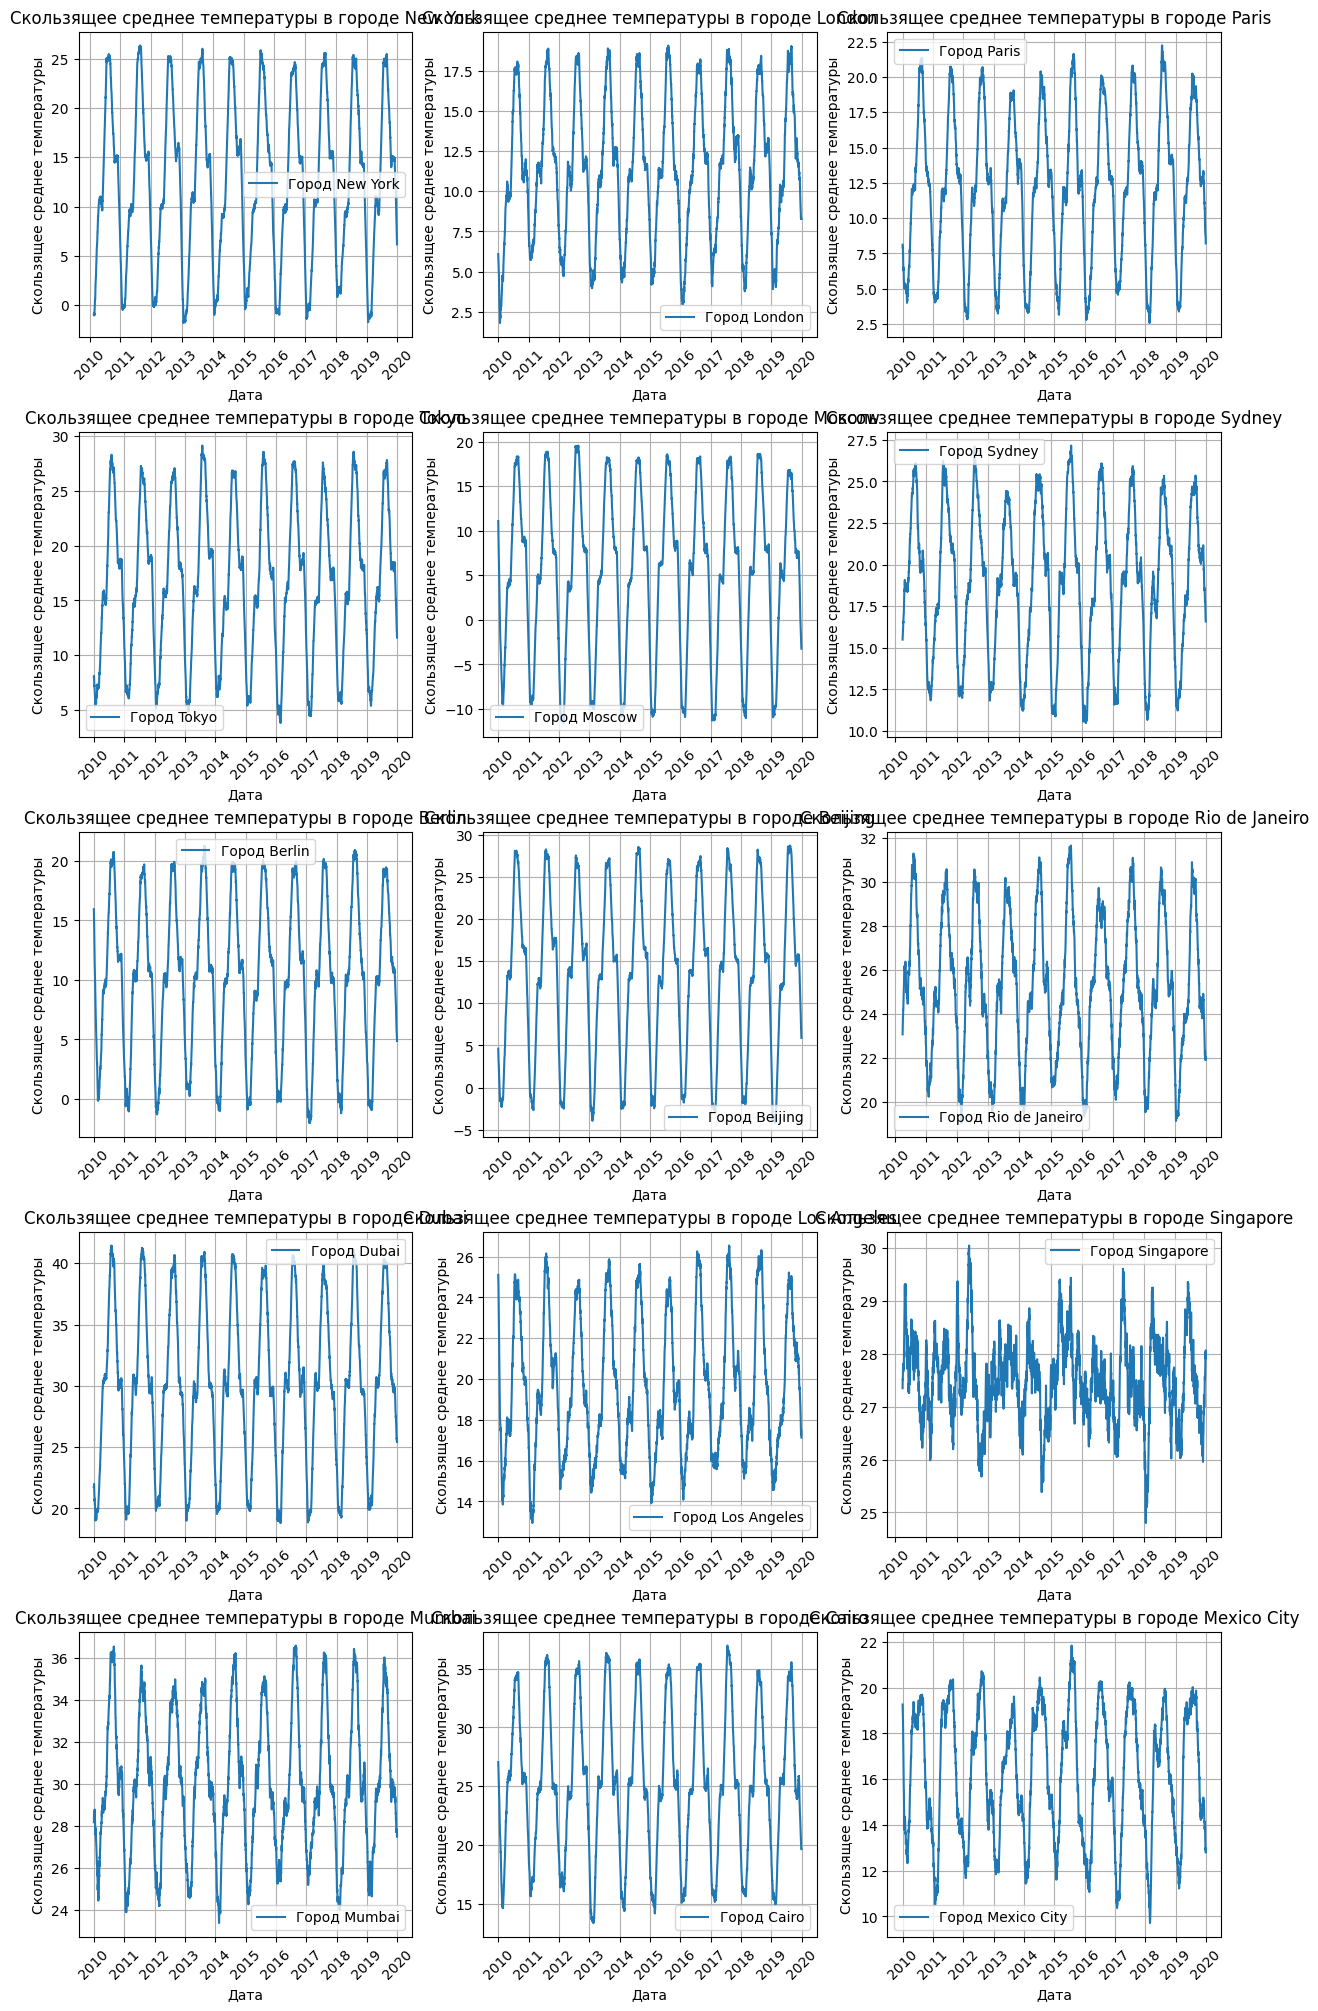

In [132]:
city_un = df['city'].unique()
num = len(city_un)
cols = 3
rows = (num + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
axes = axes.flatten()

for i, city in enumerate(city_un):
    city_data = df[df['city'] == city]
    axes[i].plot(city_data['timestamp'], city_data['MA'], label=f'Город {city}')

    axes[i].set_title(f'Скользящее среднее температуры в городе {city}')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Скользящее среднее температуры')
    axes[i].legend()
    axes[i].grid()
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [133]:
def anomalies_place(df, city):
    filtered_df = df.query(f'city == "{city}"')
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_df['timestamp'], filtered_df['temperature'], label='Температура', color='green')
    outliers = filtered_df[filtered_df['anomalies_2sigma']]
    plt.scatter(outliers['timestamp'], outliers['temperature'], color='red', label='Аномалии')
    plt.title(f'Температура в городе {city}')
    plt.xlabel('Дата')
    plt.ylabel('Температура')
    plt.legend()
    plt.grid()
    plt.show()

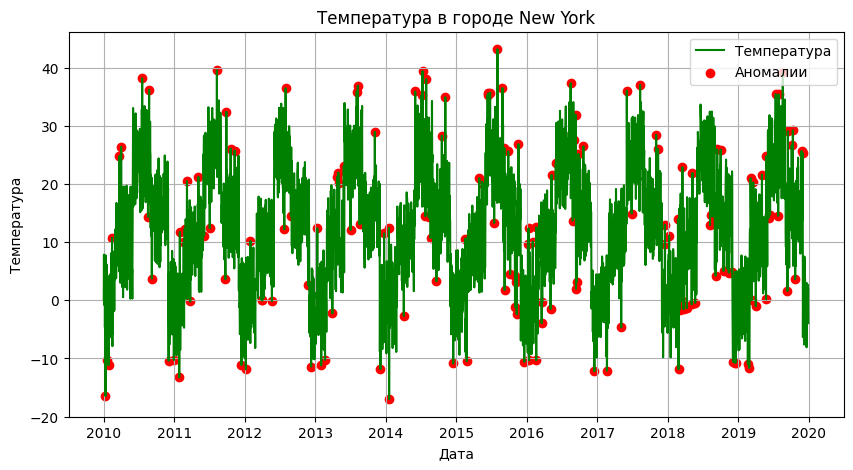

In [134]:
anomalies_place(df, 'New York')

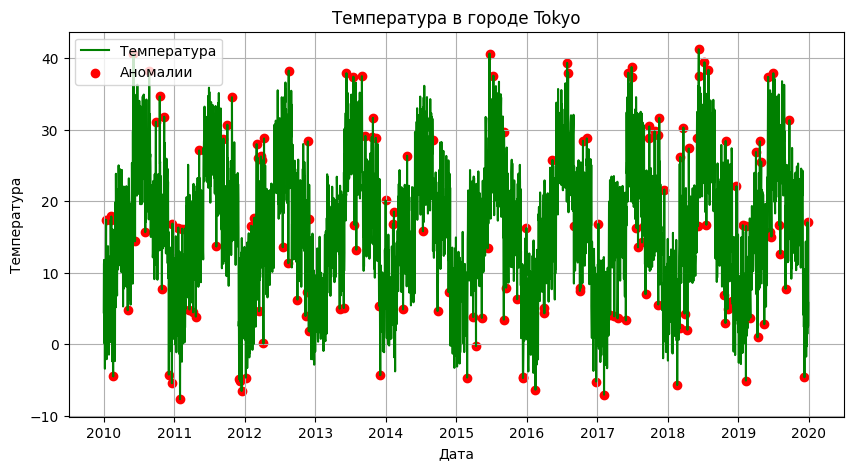

In [135]:
anomalies_place(df, 'Tokyo')

## 2. Мониторинг текущей температуры:

In [145]:
import httpx
import json
import asyncio
def current_temperature(cities, api_key):
    temperatures = {}
    for city in cities:
        try:
            with httpx.Client() as client:
                response = client.get(f'https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric')
                stat_weather_data = response.json()
                temp = stat_weather_data['main']['temp']
                temperatures[city] = temp
        except httpx.HTTPStatusError as e:
            print(f"HTTP error occurred: {e.response.status_code} - {e.response.text}")
        except httpx.RequestError as e:
            print(f"Request error occurred: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    return temperatures

async def async_weather_data(cities, api_key):
    temperatures = {}
    async with httpx.AsyncClient() as client:
        tasks = []

        for city in cities:
            tasks.append(
                client.get(f'https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric'))
        try:
            responses = await asyncio.gather(*tasks)
            results = Parallel(n_jobs=-1)(delayed(_extract_info)(response) for response in responses)
            for city_name, temp in results:
                temperatures[city_name] = temp
        except httpx.HTTPStatusError as e:
            if e.response.status_code == 401:
                return "Invalid API key. Please see https://openweathermap.org/faq#error401 for more info."
            else:
                return (f"Error HTTP: {e.response.status_code} - {e.response.text}")
        except httpx.RequestError as e:
            return f"Request Error (Ошибка запроса) : {e}"
        except Exception as e:
            return f"Unexpected Error: {e}"
    return temperatures




def _extract_info(response):
    stat_weather_data = response.json()
    temp = stat_weather_data['main']['temp']
    city_name = stat_weather_data['name']
    return city_name, temp

In [147]:
cities = ['New York', 'London', 'Paris', 'Tokyo', 'Moscow', 'Sydney',
          'Berlin', 'Beijing', 'Rio de Janeiro', 'Dubai', 'Los Angeles',
          'Singapore', 'Mumbai', 'Cairo', 'Mexico City']

api_key = input('Enter your API key (Вставьте ваш ключ API) >>')

KeyboardInterrupt: Interrupted by user

In [143]:
import time
begin_time = time.perf_counter()
city_temp = current_temperature(cities, api_key)
for city, temp in city_temp.items():
    print(f"Город {city}:        Температура {temp}°C")
end_time = time.perf_counter()
print(f"Время обработки: {end_time - begin_time:.2f} seconds")

Город New York:        Температура 0.1°C
Город London:        Температура -0.92°C
Город Paris:        Температура 1.91°C
Город Tokyo:        Температура 3.85°C
Город Moscow:        Температура 0.21°C
Город Sydney:        Температура 26.33°C
Город Berlin:        Температура 1.55°C
Город Beijing:        Температура -2.06°C
Город Rio de Janeiro:        Температура 24.98°C
Город Dubai:        Температура 18.96°C
Город Los Angeles:        Температура 18.1°C
Город Singapore:        Температура 24.58°C
Город Mumbai:        Температура 21.99°C
Город Cairo:        Температура 15.23°C
Город Mexico City:        Температура 17.75°C
Время обработки: 2.13 seconds


In [146]:
begin_time = time.perf_counter()
async def main():
    city_temp = await async_weather_data(cities, api_key)
    for city, temp in city_temp.items():
        print(f"Город {city}: Температура {temp}°C")
await main()
end_time = time.perf_counter()
print(f"Время Обработки: {end_time - begin_time:.2f} seconds")

Город New York: Температура 0.09°C
Город London: Температура -0.92°C
Город Paris: Температура 1.91°C
Город Tokyo: Температура 3.78°C
Город Moscow: Температура 0.21°C
Город Sydney: Температура 26.33°C
Город Berlin: Температура 1.55°C
Город Beijing: Температура -3.06°C
Город Rio de Janeiro: Температура 23.87°C
Город Dubai: Температура 18.96°C
Город Los Angeles: Температура 17.8°C
Город Singapore: Температура 24.61°C
Город Mumbai: Температура 21.99°C
Город Cairo: Температура 15.23°C
Город Mexico City: Температура 17.75°C
Время Обработки: 0.85 seconds


Асинхронность и многопоточность привели к ускорению с 2.13 секунд до 0,85 секунды.